# Forward inverse rendering

## Overview

The previous example demonstrated *reverse-mode differentiation* (a.k.a. backpropagation) where a desired small change to the output image was converted into a small change to the scene parameters. Mitsuba and DrJIT can also propagate derivatives in the other direction, i.e., from input parameters to the output image. This technique, known as *forward mode differentiation*, is not usable for optimization, as each parameter must be handled using a separate rendering pass. That said, this mode can be very educational since it enables visualizations of the effect of individual scene parameters on the rendered image.

<div class="admonition important alert alert-block alert-info">

🚀 **What will you learn?**
    
<ul>
  <li>Manually setting variables as differentiable</li>
  <li>Perform forward-mode differentiation with DrJit</li>
</ul>
    
</div>

## Step 1 - Setup

As in the previous tutorial, we set a AD-compatible variant (here `llvm_ad_rgb`) and load the Cornell Box scene.

In [1]:
import drjit as dr
import mitsuba as mi

mi.set_variant('llvm_ad_rgb')

scene = mi.load_file('../../scenes/cbox.xml')

2022-03-28 09:26:46 INFO main [xml.cpp:1260] Loading XML file "../../scenes/cbox.xml" with variant "llvm_ad_rgb"..

2022-03-28 09:26:46 INFO main [Scene] Embree ready. (took 0ms)

2022-03-28 09:26:46 INFO main [xml.cpp:1319] Done loading XML file "../../scenes/cbox.xml" (took 14ms).

## Step 2 - Prepare scene

Forward mode differentiable rendering begins analogously to reverse mode, by marking the parameters of interest as differnetiable (in this tutorial, we do so manually instead of using an `Optimizer`). 

In this tutorial, we are going to visualize the effect of the color parameter of the green wall on the final image. Note that we are rendering this image using a physically-based *path tracer*, which properly accounts for globlal illumination, reflection, refraction, etc, ...

In [2]:
# Get the scene parameters
params = mi.traverse(scene)

# Mark the green wall color parameter as differentiable
dr.enable_grad(params['green.reflectance.value'])

# Propagate this change to the scene internal state
params.update()

## Step 3 - Rendering

We can then perform the simulation to be differentiated. In this case, we simply render an image using the `mi.render()` routine.


The `dr.forward` function will assign a gradient value of one to the given variables and forward-propagate those gradients through the previously recorded computation graph. During this process, gradient will be accumulated in the output nodes of this graph, (here the rendered image) which can be read using the `dr.grad` value.

For more detailed information about differentiation with DrJit, please refer to the [documentation](...).

In [3]:
# Differentiable simulation
image = mi.render(scene, params, spp=512)

# Forward-propagate gradients through the computation graph
dr.forward(params['green.reflectance.value'])

# Fetch the image gradient values
grad_image = dr.grad(image)

2022-03-28 09:26:46 INFO main [SamplingIntegrator] Starting render job (256x256, 512 samples)

2022-03-28 09:26:46 INFO main [SamplingIntegrator] Computation graph recorded. (took 2ms)

2022-03-28 09:26:50 INFO main [SamplingIntegrator] Starting render job (256x256, 512 samples)

The gradient value of the `image` variable will share the same type (here `TensorXf`) hence it can easily be visualized using `matplotlib`.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


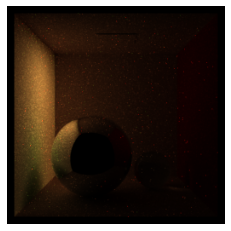

In [4]:
import matplotlib.pyplot as plt
plt.imshow(grad_image); 
plt.axis('off');

## *Reference API*

- [<code>mitsuba.core.load_file</code>](https://mitsuba2.readthedocs.io/en/latest/generated/core_api.html#mitsuba.core.load_file)